In [1]:
from keratin.metrics import dice, dice_loss
import numpy as np
from keratin.networks import unet
from keras.optimizers import Adam
from skimage.transform import resize
import keras
import matplotlib.pyplot as plt
import numpy as np
#%pylab inline

Using TensorFlow backend.
Failed to import duecredit due to No module named 'duecredit'


In [2]:
model = unet(256,256,n_channels=2)

/home/keshavan/software/keratin/keratin/networks.py:89: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  return km.Model(input=inputs, outputs=outputs)


In [3]:
model.compile(optimizer=Adam(lr=10e-5), 
              loss=dice_loss, 
              metrics=[dice])

In [4]:
from glob import glob

In [5]:
images = sorted(glob("../tiles/*/base*.jpg"))
hints = sorted(glob("../tiles/*/agg*.png"))
masks =sorted(glob("../tiles/*/truth*.png"))

def make256(images, hints = None):
    
    if not hints:
        bigM = np.zeros((len(images), 256, 256, 1))
    else:
        bigM = np.zeros((len(images), 256, 256, 2))
    
    for i, im in enumerate(images):

        data = plt.imread(im)
        if len(data.shape) == 3:
            do_mean = True
            data = (data[:,:,0]/255).astype(np.float32)
            if hints:
                hint = plt.imread(hints[i]).astype(np.float32)
            
        else:
            do_mean = False
            #print("mean_data", np.mean(data))
            data = (data/np.max(data)).astype(np.float32)
            #print("mean data", np.mean(data))

        if data.shape[0] > 256:
            data = data[:256, :]
        if data.shape[1] > 256:
            data = data[:, :256]

        data_pad = np.pad(data, (((256-data.shape[0])//2, ((256-data.shape[0]) + (data.shape[0]%2 >0))//2), 
                                 ((256-data.shape[1])//2, ((256-data.shape[1]) + (data.shape[1]%2 >0))//2)), 
                          "constant", constant_values = (0,0))
        
        if hints:
            
            if hint.shape[0] > 256:
                hint = hint[:256, :]
            if hint.shape[1] > 256:
                hint = hint[:, :256]
            
            hint_pad = np.pad(hint, (((256-hint.shape[0])//2, ((256-hint.shape[0]) + (hint.shape[0]%2 >0))//2), 
                         ((256-hint.shape[1])//2, ((256-hint.shape[1]) + (hint.shape[1]%2 >0))//2)), 
                  "constant", constant_values = (0,0))

        
        if do_mean:
            bigM[i,:,:,0] = (data_pad - np.mean(data_pad)) / np.std(data_pad)
            if hints:
                bigM[i,:,:,1] = (hint_pad - np.mean(hint_pad)) / np.std(hint_pad)
            
            #bigM_mean = np.mean(bigM)
            #bigM_std = np.std(bigM)
            #bigM = (bigM - bigM_mean)/bigM_std
        else:
            bigM[i,:,:,0] = data_pad
        
    return bigM

In [6]:
assert(len(images) == len(masks))

In [7]:
assert(len(hints) == len(masks))

In [8]:
images[0]

'../tiles/sub000/base002.jpg'

In [9]:
subjects_all = [i.split("/")[-2] for i in images]

In [10]:
subjects = np.asarray(sorted(list(set(subjects_all))))

In [11]:
subjects

array(['sub000', 'sub001', 'sub002', 'sub003', 'sub005', 'sub006',
       'sub007', 'sub008', 'sub010', 'sub011', 'sub013', 'sub014',
       'sub015', 'sub017', 'sub020', 'sub021', 'sub022', 'sub023',
       'sub025', 'sub026', 'sub029', 'sub030', 'sub031'],
      dtype='<U6')

In [12]:
bigM_base = make256(images, hints)
bigM_base.shape

(188, 256, 256, 2)

In [13]:
#masks = glob("../tiles/s*/truth*.png")
bigM_mask = make256(masks)
bigM_mask.shape

(188, 256, 256, 1)

In [14]:
bigM_mask[0,:,:,0].any()

True

In [15]:
idx = list(range(len(set(subjects))))
np.random.shuffle(idx)

In [16]:
subjects[idx]

array(['sub022', 'sub029', 'sub013', 'sub020', 'sub002', 'sub030',
       'sub007', 'sub017', 'sub026', 'sub005', 'sub010', 'sub001',
       'sub006', 'sub015', 'sub008', 'sub011', 'sub025', 'sub021',
       'sub000', 'sub023', 'sub014', 'sub031', 'sub003'],
      dtype='<U6')

In [17]:
len(subjects)

23

In [18]:
train_subs = idx[:int(0.8*subjects.shape[0])]
test_subs = idx[int(0.8*subjects.shape[0]):int(0.9*subjects.shape[0])]
val_subs = idx[int(0.9*subjects.shape[0]):]

In [19]:
subjects[train_subs]

array(['sub022', 'sub029', 'sub013', 'sub020', 'sub002', 'sub030',
       'sub007', 'sub017', 'sub026', 'sub005', 'sub010', 'sub001',
       'sub006', 'sub015', 'sub008', 'sub011', 'sub025', 'sub021'],
      dtype='<U6')

In [20]:
subjects[test_subs]

array(['sub000', 'sub023'],
      dtype='<U6')

In [21]:
subjects[val_subs]

array(['sub014', 'sub031', 'sub003'],
      dtype='<U6')

In [22]:
train = [i for i, val in enumerate(subjects_all) if val in subjects[train_subs]]
np.random.shuffle(train)
test = [i for i, val in enumerate(subjects_all) if val in subjects[test_subs]]
np.random.shuffle(test)
val = [i for i, val in enumerate(subjects_all) if val in subjects[val_subs]]
np.random.shuffle(val)

In [23]:
#back when i didn't split by subject

#train = idx[:int(0.8*bigM_base.shape[0])]
#test = idx[int(0.8*bigM_base.shape[0]):int(0.9*bigM_base.shape[0])]
#val = idx[int(0.9*bigM_base.shape[0]):]

In [24]:
x_train = bigM_base[train, :]
y_train = bigM_mask[train, :]

x_test = bigM_base[test, :]
y_test = bigM_mask[test, :]

x_val = bigM_base[val, :]
y_val = bigM_mask[val, :]


In [25]:
x_train.shape

(133, 256, 256, 2)

**AK:** `killall python` to free up GPU memory (you only have 3.9GB)

`nvidia smi` to monitor usage

apparently this uses 3.4GB already

In [26]:
model.fit(x_train, y_train, batch_size=4, 
          epochs=10, verbose=1, validation_data=(x_val, y_val), 
          callbacks=[keras.callbacks.TensorBoard(log_dir='./logs_newsplit', histogram_freq=0, 
                                                 batch_size=4, write_graph=True, 
                                                 write_grads=True, write_images=True, 
                                                 embeddings_freq=0, embeddings_layer_names=None, 
                                                 embeddings_metadata=None),
                     keras.callbacks.ModelCheckpoint("./checkpoints_newsplit", monitor='val_dice', 
                                                     verbose=0, save_best_only=False, save_weights_only=False, 
                                                     mode='auto', period=1)
                    ]
)

Train on 133 samples, validate on 32 samples
Epoch 1/10
133/133 [==============================] - 16s - loss: -0.1227 - dice: 0.1227 - val_loss: -0.7938 - val_dice: 0.7938
Epoch 2/10
133/133 [==============================] - 10s - loss: -0.8146 - dice: 0.8146 - val_loss: -0.8540 - val_dice: 0.8540
Epoch 3/10
133/133 [==============================] - 10s - loss: -0.8559 - dice: 0.8559 - val_loss: -0.8971 - val_dice: 0.8971
Epoch 4/10
133/133 [==============================] - 10s - loss: -0.8515 - dice: 0.8515 - val_loss: -0.9103 - val_dice: 0.9103
Epoch 5/10
133/133 [==============================] - 10s - loss: -0.8648 - dice: 0.8648 - val_loss: -0.9235 - val_dice: 0.9235
Epoch 6/10
133/133 [==============================] - 10s - loss: -0.8630 - dice: 0.8630 - val_loss: -0.9228 - val_dice: 0.9228
Epoch 7/10
133/133 [==============================] - 10s - loss: -0.8657 - dice: 0.8657 - val_loss: -0.9302 - val_dice: 0.9302
Epoch 8/10
133/133 [==============================] - 10s -

In [27]:
score = model.evaluate(x_test, y_test)
score

23/23 [==============================] - 2s


[-0.95072472095489502, 0.95072472095489502]

In [28]:
y_pred = model.predict(x_test)

In [29]:
y_pred.shape

(23, 256, 256, 1)

In [30]:
y_test.shape

(23, 256, 256, 1)

/home/keshavan/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


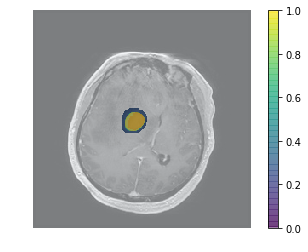

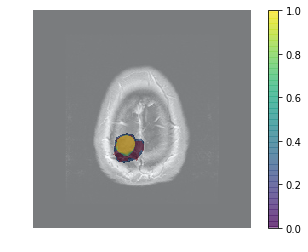

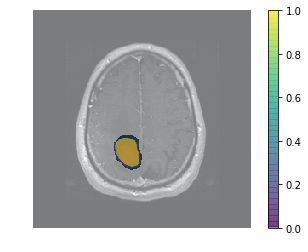

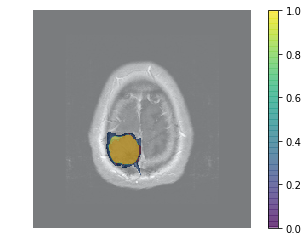

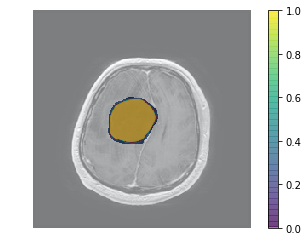

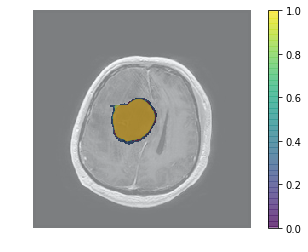

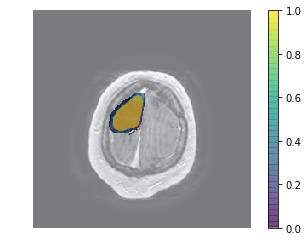

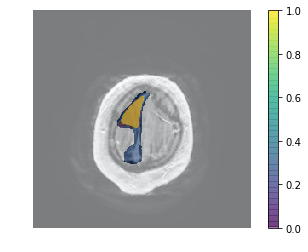

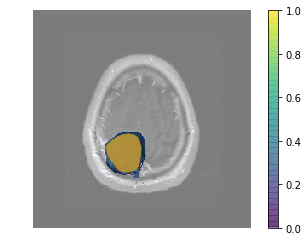

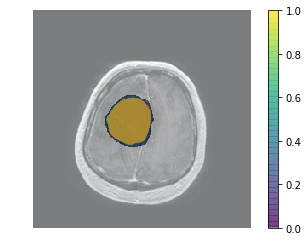

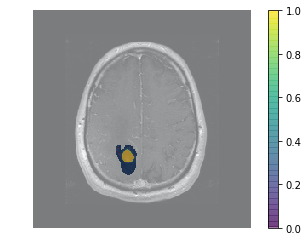

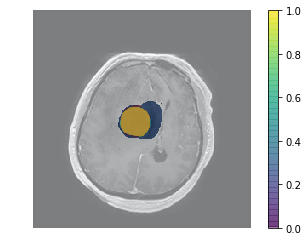

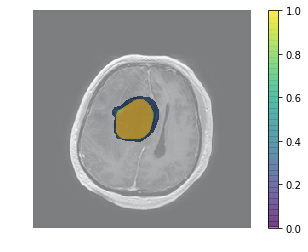

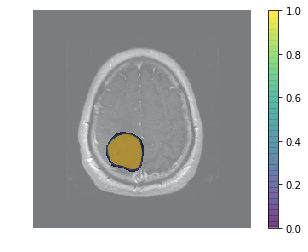

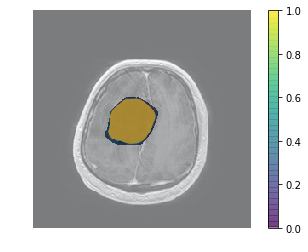

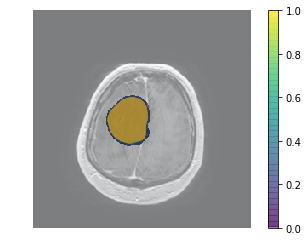

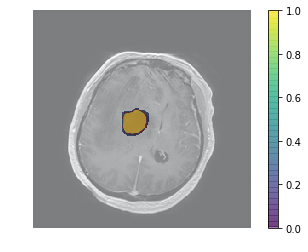

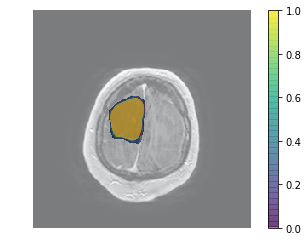

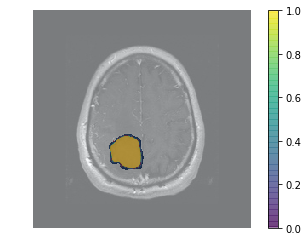

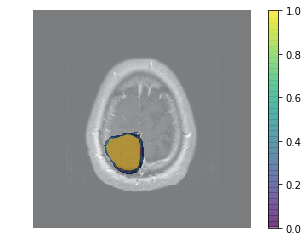

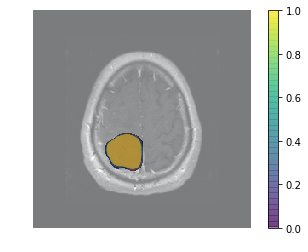

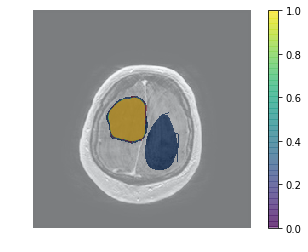

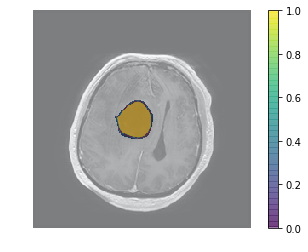

In [31]:
%matplotlib inline
for i in range(x_test.shape[0]):
    plt.figure(i)
    plt.imshow(x_test[i,:,:,0].reshape(256,256), cmap=plt.cm.Greys_r)
    
    hint = x_test[i,:,:,1].reshape(256,256)
    hint[hint==0] = np.nan
    plt.imshow(hint, cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    
    truth = y_test[i,:,:,0].reshape(256,256)
    truth[truth==0] = np.nan
    plt.imshow(truth, cmap=plt.cm.Reds, vmin=0, vmax=1, alpha=0.5)
    
    roi = y_pred[i,:,:,0].reshape(256,256)
    roi[roi<0.5] = np.nan
    plt.imshow(roi, alpha=0.5, vmin=0, vmax=1)
    plt.axis("off")
    plt.colorbar()

# run tensorboard

```bash
tensorboard --log ./logs
```

## TODOS:

* standardization
* add "hint" channel but smooth first
* bug satra to give more data

(array([ 6718716.,   496062.,   786554.,   940865.,   431133.,   200500.,
          124068.,    85131.,    39736.,     7635.]),
 array([   0. ,   25.5,   51. ,   76.5,  102. ,  127.5,  153. ,  178.5,
         204. ,  229.5,  255. ]),
 <a list of 10 Patch objects>)

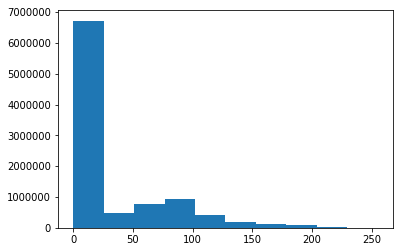

In [87]:
hist(x_train.ravel())